In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [ ]:
# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-11-24' # 2
config_name = 'config_001_hollow10MR.yaml' # 'config_001_ebert10M.yaml'
model_name = 'model_86999.pt' #  'model_24999.pt'

#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [ ]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'CRMLBJF' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.logit_type = 'Direct'
cfg.sampler.num_corrector_steps = 3
cfg.sampler.corrector_entry_time = ScalarFloat(0.2)
cfg.sampler.num_steps = 10000
cfg.sampler.is_ordinal = True

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

In [15]:
n_samples = 64
samples = sampler.sample(model, n_samples)
saved_samples = samples

corrector
corrector


8506it [11:05,  3.72it/s]

corrector


8508it [11:06,  3.83it/s]

corrector
corrector


8509it [11:06,  3.82it/s]

corrector


8511it [11:07,  3.78it/s]

corrector
corrector


8512it [11:07,  3.90it/s]

corrector


8514it [11:08,  3.69it/s]

corrector
corrector


8515it [11:08,  4.01it/s]

corrector


8517it [11:08,  3.59it/s]

corrector


8518it [11:09,  4.00it/s]

corrector
corrector


8520it [11:09,  3.51it/s]

corrector


8521it [11:09,  3.93it/s]

corrector
corrector


8522it [11:10,  3.61it/s]

corrector


8524it [11:10,  3.87it/s]

corrector
corrector


8525it [11:10,  3.73it/s]

corrector


8527it [11:11,  3.82it/s]

corrector
corrector


8528it [11:11,  3.83it/s]

corrector


8530it [11:12,  3.76it/s]

corrector
corrector


8531it [11:12,  3.91it/s]

corrector


8533it [11:13,  3.68it/s]

corrector
corrector


8534it [11:13,  4.03it/s]

corrector


8536it [11:14,  3.58it/s]

corrector


8537it [11:14,  3.99it/s]

corrector
corrector


8538it [11:14,  3.58it/s]

corrector


8540it [11:15,  3.91it/s]

corrector
corrector


8541it [11:15,  3.67it/s]

corrector


8543it [11:15,  3.86it/s]

corrector
corrector


8544it [11:16,  3.73it/s]

corrector


8546it [11:16,  3.81it/s]

corrector
corrector


8547it [11:16,  3.85it/s]

corrector


8549it [11:17,  3.75it/s]

corrector
corrector


8550it [11:17,  3.98it/s]

corrector


8552it [11:18,  3.65it/s]

corrector
corrector


8553it [11:18,  3.98it/s]

corrector


8555it [11:19,  3.57it/s]

corrector


8556it [11:19,  3.98it/s]

corrector
corrector


8558it [11:20,  3.50it/s]

corrector


8559it [11:20,  3.92it/s]

corrector
corrector


8560it [11:20,  3.64it/s]

corrector


8562it [11:21,  3.86it/s]

corrector
corrector


8563it [11:21,  3.73it/s]

corrector


8565it [11:21,  3.82it/s]

corrector
corrector


8566it [11:22,  3.84it/s]

corrector


8568it [11:22,  3.76it/s]

corrector
corrector


8569it [11:22,  3.92it/s]

corrector


8571it [11:23,  3.68it/s]

corrector
corrector


8572it [11:23,  4.03it/s]

corrector


8574it [11:24,  3.58it/s]

corrector


8575it [11:24,  4.00it/s]

corrector
corrector


8577it [11:25,  3.50it/s]

corrector


8578it [11:25,  3.93it/s]

corrector
corrector


8579it [11:25,  3.64it/s]

corrector


8581it [11:26,  3.87it/s]

corrector
corrector


8582it [11:26,  3.74it/s]

corrector


8584it [11:27,  3.82it/s]

corrector
corrector


8585it [11:27,  3.85it/s]

corrector


8587it [11:27,  3.75it/s]

corrector
corrector


8588it [11:28,  3.98it/s]

corrector


8590it [11:28,  3.66it/s]

corrector
corrector


8591it [11:28,  4.05it/s]

corrector


8593it [11:29,  3.56it/s]

corrector


8594it [11:29,  3.98it/s]

corrector
corrector


8595it [11:30,  3.58it/s]

corrector


8597it [11:30,  3.91it/s]

corrector
corrector


8598it [11:30,  3.68it/s]

corrector


8600it [11:31,  3.85it/s]

corrector
corrector


8601it [11:31,  3.72it/s]

corrector


8603it [11:32,  3.81it/s]

corrector
corrector


8604it [11:32,  3.84it/s]

corrector


8606it [11:33,  3.75it/s]

corrector
corrector


8607it [11:33,  3.96it/s]

corrector


8609it [11:33,  3.66it/s]

corrector
corrector


8610it [11:34,  4.03it/s]

corrector


8612it [11:34,  3.57it/s]

corrector


8613it [11:34,  3.99it/s]

corrector
corrector


8614it [11:35,  3.60it/s]

corrector


8616it [11:35,  3.91it/s]

corrector
corrector


8617it [11:36,  3.69it/s]

corrector


8619it [11:36,  3.84it/s]

corrector
corrector


8620it [11:36,  3.81it/s]

corrector


8622it [11:37,  3.79it/s]

corrector
corrector


8623it [11:37,  3.87it/s]

corrector


8625it [11:38,  3.71it/s]

corrector
corrector


8626it [11:38,  4.01it/s]

corrector


8628it [11:39,  3.60it/s]

corrector


8629it [11:39,  4.02it/s]

corrector
corrector


8630it [11:39,  3.58it/s]

corrector


8632it [11:40,  3.93it/s]

corrector
corrector


8633it [11:40,  3.68it/s]

corrector


8635it [11:40,  3.87it/s]

corrector
corrector


8636it [11:41,  3.75it/s]

corrector


8638it [11:41,  3.80it/s]

corrector
corrector


8639it [11:42,  3.85it/s]

corrector


8641it [11:42,  3.75it/s]

corrector
corrector


8642it [11:42,  3.99it/s]

corrector


8644it [11:43,  3.65it/s]

corrector
corrector


8645it [11:43,  4.04it/s]

corrector


8647it [11:44,  3.56it/s]

corrector


8648it [11:44,  3.98it/s]

corrector
corrector


8649it [11:44,  3.58it/s]

corrector


8651it [11:45,  3.90it/s]

corrector
corrector


8652it [11:45,  3.69it/s]

corrector


8654it [11:46,  3.85it/s]

corrector
corrector


8655it [11:46,  3.78it/s]

corrector


8657it [11:46,  3.80it/s]

corrector
corrector


8658it [11:47,  3.88it/s]

corrector


8660it [11:47,  3.73it/s]

corrector
corrector


8661it [11:47,  3.97it/s]

corrector


8663it [11:48,  3.64it/s]

corrector
corrector


8664it [11:48,  4.04it/s]

corrector


8666it [11:49,  3.55it/s]

corrector


8667it [11:49,  3.96it/s]

corrector
corrector


8668it [11:49,  3.59it/s]

corrector


8670it [11:50,  3.89it/s]

corrector
corrector


8671it [11:50,  3.68it/s]

corrector


8673it [11:51,  3.85it/s]

corrector
corrector


8674it [11:51,  3.77it/s]

corrector


8676it [11:52,  3.80it/s]

corrector
corrector


8677it [11:52,  3.89it/s]

corrector


8679it [11:52,  3.72it/s]

corrector
corrector


8680it [11:53,  4.02it/s]

corrector


8682it [11:53,  3.61it/s]

corrector


8683it [11:53,  4.02it/s]

corrector
corrector


8685it [11:54,  3.52it/s]

corrector


8686it [11:54,  3.94it/s]

corrector
corrector


8687it [11:55,  3.60it/s]

corrector


8689it [11:55,  3.88it/s]

corrector
corrector


8690it [11:55,  3.72it/s]

corrector


8692it [11:56,  3.84it/s]

corrector
corrector


8693it [11:56,  3.82it/s]

corrector


8695it [11:57,  3.78it/s]

corrector
corrector


8696it [11:57,  3.91it/s]

corrector


8698it [11:58,  3.69it/s]

corrector
corrector


8699it [11:58,  4.03it/s]

corrector


8701it [11:58,  3.59it/s]

corrector


8702it [11:59,  4.00it/s]

corrector
corrector


8703it [11:59,  3.57it/s]

corrector


8705it [11:59,  3.91it/s]

corrector
corrector


8706it [12:00,  3.72it/s]

corrector


8708it [12:00,  3.85it/s]

corrector
corrector


8709it [12:01,  3.82it/s]

corrector


8711it [12:01,  3.79it/s]

corrector
corrector


8712it [12:01,  3.92it/s]

corrector


8714it [12:02,  3.69it/s]

corrector
corrector


8715it [12:02,  4.02it/s]

corrector


8717it [12:03,  3.59it/s]

corrector


8718it [12:03,  4.00it/s]

corrector
corrector


8719it [12:03,  3.55it/s]

corrector


8721it [12:04,  3.92it/s]

corrector
corrector


8722it [12:04,  3.61it/s]

corrector


8724it [12:05,  3.87it/s]

corrector
corrector


8725it [12:05,  3.74it/s]

corrector


8727it [12:05,  3.82it/s]

corrector
corrector


8728it [12:06,  3.86it/s]

corrector


8730it [12:06,  3.75it/s]

corrector
corrector


8731it [12:07,  3.99it/s]

corrector


8733it [12:07,  3.65it/s]

corrector
corrector


8734it [12:07,  4.06it/s]

corrector


8736it [12:08,  3.54it/s]

corrector


8737it [12:08,  3.96it/s]

corrector
corrector


8738it [12:08,  3.59it/s]

corrector


8740it [12:09,  3.89it/s]

corrector
corrector


8741it [12:09,  3.69it/s]

corrector


8743it [12:10,  3.84it/s]

corrector
corrector


8744it [12:10,  3.77it/s]

corrector


8746it [12:11,  3.80it/s]

corrector
corrector


8747it [12:11,  3.89it/s]

corrector


8749it [12:11,  3.72it/s]

corrector
corrector


8750it [12:12,  4.04it/s]

corrector


8752it [12:12,  3.60it/s]

corrector


8753it [12:13,  4.01it/s]

corrector
corrector


8754it [12:13,  3.57it/s]

corrector


8756it [12:13,  3.92it/s]

corrector
corrector


8757it [12:14,  3.64it/s]

corrector


8759it [12:14,  3.86it/s]

corrector
corrector


8760it [12:14,  3.73it/s]

corrector


8762it [12:15,  3.82it/s]

corrector
corrector


8763it [12:15,  3.84it/s]

corrector


8765it [12:16,  3.76it/s]

corrector
corrector


8766it [12:16,  3.97it/s]

corrector


8768it [12:17,  3.66it/s]

corrector
corrector


8769it [12:17,  4.05it/s]

corrector


8771it [12:17,  3.56it/s]

corrector


8772it [12:18,  3.97it/s]

corrector
corrector


8773it [12:18,  3.60it/s]

corrector


8775it [12:19,  3.91it/s]

corrector
corrector


8776it [12:19,  3.72it/s]

corrector


8778it [12:19,  3.84it/s]

corrector
corrector


8779it [12:20,  3.72it/s]

corrector


8781it [12:20,  3.81it/s]

corrector
corrector


8782it [12:20,  3.86it/s]

corrector


8784it [12:21,  3.73it/s]

corrector
corrector


8785it [12:21,  3.99it/s]

corrector


8787it [12:22,  3.63it/s]

corrector
corrector


8788it [12:22,  4.04it/s]

corrector


8790it [12:23,  3.53it/s]

corrector


8791it [12:23,  3.96it/s]

corrector
corrector


8792it [12:23,  3.61it/s]

corrector


8794it [12:24,  3.89it/s]

corrector
corrector


8795it [12:24,  3.74it/s]

corrector


8797it [12:25,  3.83it/s]

corrector
corrector


8798it [12:25,  3.85it/s]

corrector


8800it [12:25,  3.75it/s]

corrector
corrector


8801it [12:26,  3.98it/s]

corrector


8803it [12:26,  3.65it/s]

corrector
corrector


8804it [12:26,  4.04it/s]

corrector


8806it [12:27,  3.56it/s]

corrector


8807it [12:27,  3.97it/s]

corrector
corrector


8808it [12:28,  3.59it/s]

corrector


8810it [12:28,  3.90it/s]

corrector
corrector


8811it [12:28,  3.68it/s]

corrector


8813it [12:29,  3.85it/s]

corrector
corrector


8814it [12:29,  3.75it/s]

corrector


8816it [12:30,  3.80it/s]

corrector
corrector


8817it [12:30,  3.86it/s]

corrector


8819it [12:31,  3.74it/s]

corrector
corrector


8820it [12:31,  3.97it/s]

corrector


8822it [12:31,  3.64it/s]

corrector
corrector


8823it [12:32,  4.02it/s]

corrector


8825it [12:32,  3.55it/s]

corrector


8826it [12:32,  3.97it/s]

corrector
corrector


8827it [12:33,  3.58it/s]

corrector


8829it [12:33,  3.91it/s]

corrector
corrector


8830it [12:34,  3.69it/s]

corrector


8832it [12:34,  3.84it/s]

corrector
corrector


8833it [12:34,  3.75it/s]

corrector


8835it [12:35,  3.80it/s]

corrector
corrector


8836it [12:35,  3.87it/s]

corrector


8838it [12:36,  3.73it/s]

corrector
corrector


8839it [12:36,  4.02it/s]

corrector


8841it [12:37,  3.61it/s]

corrector


8842it [12:37,  4.02it/s]

corrector
corrector


8844it [12:37,  3.51it/s]

corrector


8845it [12:38,  3.93it/s]

corrector
corrector


8846it [12:38,  3.68it/s]

corrector


8848it [12:38,  3.86it/s]

corrector
corrector


8849it [12:39,  3.75it/s]

corrector


8851it [12:39,  3.82it/s]

corrector
corrector


8852it [12:39,  3.88it/s]

corrector


8854it [12:40,  3.73it/s]

corrector
corrector


8855it [12:40,  4.02it/s]

corrector


8857it [12:41,  3.62it/s]

corrector


8858it [12:41,  4.03it/s]

corrector
corrector


8860it [12:42,  3.52it/s]

corrector


8861it [12:42,  3.93it/s]

corrector
corrector


8862it [12:42,  3.64it/s]

corrector


8864it [12:43,  3.87it/s]

corrector
corrector


8865it [12:43,  3.74it/s]

corrector


8867it [12:44,  3.82it/s]

corrector
corrector


8868it [12:44,  3.84it/s]

corrector


8870it [12:44,  3.75it/s]

corrector
corrector


8871it [12:45,  3.90it/s]

corrector


8873it [12:45,  3.68it/s]

corrector
corrector


8874it [12:45,  4.03it/s]

corrector


8876it [12:46,  3.58it/s]

corrector


8877it [12:46,  3.99it/s]

corrector
corrector


8879it [12:47,  3.50it/s]

corrector


8880it [12:47,  3.92it/s]

corrector
corrector


8881it [12:47,  3.64it/s]

corrector


8883it [12:48,  3.87it/s]

corrector
corrector


8884it [12:48,  3.74it/s]

corrector


8886it [12:49,  3.81it/s]

corrector
corrector


8887it [12:49,  3.82it/s]

corrector


8889it [12:50,  3.77it/s]

corrector
corrector


8890it [12:50,  3.94it/s]

corrector


8892it [12:50,  3.68it/s]

corrector
corrector


8893it [12:51,  4.03it/s]

corrector


8895it [12:51,  3.58it/s]

corrector


8896it [12:51,  3.99it/s]

corrector
corrector


8898it [12:52,  3.50it/s]

corrector


8899it [12:52,  3.92it/s]

corrector
corrector


8900it [12:53,  3.61it/s]

corrector


8902it [12:53,  3.87it/s]

corrector
corrector


8903it [12:53,  3.73it/s]

corrector


8905it [12:54,  3.82it/s]

corrector
corrector


8906it [12:54,  3.85it/s]

corrector


8908it [12:55,  3.75it/s]

corrector
corrector


8909it [12:55,  3.97it/s]

corrector


8911it [12:56,  3.65it/s]

corrector
corrector


8912it [12:56,  4.05it/s]

corrector


8914it [12:56,  3.56it/s]

corrector


8915it [12:57,  3.98it/s]

corrector
corrector


8916it [12:57,  3.60it/s]

corrector


8918it [12:57,  3.91it/s]

corrector
corrector


8919it [12:58,  3.72it/s]

corrector


8921it [12:58,  3.84it/s]

corrector
corrector


8922it [12:59,  3.74it/s]

corrector


8924it [12:59,  3.80it/s]

corrector
corrector


8925it [12:59,  3.91it/s]

corrector


8927it [13:00,  3.71it/s]

corrector
corrector


8928it [13:00,  4.00it/s]

corrector


8930it [13:01,  3.61it/s]

corrector


8931it [13:01,  4.02it/s]

corrector
corrector


8933it [13:02,  3.52it/s]

corrector


8934it [13:02,  3.94it/s]

corrector
corrector


8935it [13:02,  3.61it/s]

corrector


8937it [13:03,  3.89it/s]

corrector
corrector


8938it [13:03,  3.74it/s]

corrector


8940it [13:03,  3.83it/s]

corrector
corrector


8941it [13:04,  3.83it/s]

corrector


8943it [13:04,  3.77it/s]

corrector
corrector


8944it [13:05,  3.93it/s]

corrector


8946it [13:05,  3.68it/s]

corrector
corrector


8947it [13:05,  4.04it/s]

corrector


8949it [13:06,  3.59it/s]

corrector


8950it [13:06,  4.00it/s]

corrector
corrector


8951it [13:06,  3.56it/s]

corrector


8953it [13:07,  3.92it/s]

corrector
corrector


8954it [13:07,  3.67it/s]

corrector


8956it [13:08,  3.86it/s]

corrector
corrector


8957it [13:08,  3.73it/s]

corrector


8959it [13:09,  3.82it/s]

corrector
corrector


8960it [13:09,  3.86it/s]

corrector


8962it [13:09,  3.75it/s]

corrector
corrector


8963it [13:10,  3.98it/s]

corrector


8965it [13:10,  3.65it/s]

corrector
corrector


8966it [13:10,  4.04it/s]

corrector


8968it [13:11,  3.56it/s]

corrector


8969it [13:11,  3.98it/s]

corrector
corrector


8970it [13:12,  3.57it/s]

corrector


8972it [13:12,  3.91it/s]

corrector
corrector


8973it [13:12,  3.64it/s]

corrector


8975it [13:13,  3.85it/s]

corrector
corrector


8976it [13:13,  3.73it/s]

corrector


8978it [13:14,  3.81it/s]

corrector
corrector


8979it [13:14,  3.85it/s]

corrector


8981it [13:15,  3.75it/s]

corrector
corrector


8982it [13:15,  3.97it/s]

corrector


8984it [13:15,  3.65it/s]

corrector
corrector


8985it [13:16,  4.05it/s]

corrector


8987it [13:16,  3.55it/s]

corrector


8988it [13:16,  3.96it/s]

corrector
corrector


8989it [13:17,  3.58it/s]

corrector


8991it [13:17,  3.90it/s]

corrector
corrector


8992it [13:18,  3.71it/s]

corrector


8994it [13:18,  3.84it/s]

corrector
corrector


8995it [13:18,  3.80it/s]

corrector


8997it [13:19,  3.79it/s]

corrector
corrector


8998it [13:19,  3.90it/s]

corrector


9000it [13:20,  3.70it/s]

corrector
corrector


9001it [13:20,  4.02it/s]

corrector


9003it [13:21,  3.59it/s]

corrector


9004it [13:21,  4.00it/s]

corrector
corrector


9005it [13:21,  3.57it/s]

corrector


9007it [13:22,  3.92it/s]

corrector
corrector


9008it [13:22,  3.68it/s]

corrector


9010it [13:22,  3.85it/s]

corrector
corrector


9011it [13:23,  3.72it/s]

corrector


9013it [13:23,  3.81it/s]

corrector
corrector


9014it [13:24,  3.84it/s]

corrector


9016it [13:24,  3.76it/s]

corrector
corrector


9017it [13:24,  3.99it/s]

corrector


9019it [13:25,  3.66it/s]

corrector
corrector


9020it [13:25,  4.03it/s]

corrector


9022it [13:26,  3.56it/s]

corrector


9023it [13:26,  3.97it/s]

corrector
corrector


9024it [13:26,  3.58it/s]

corrector


9026it [13:27,  3.91it/s]

corrector
corrector


9027it [13:27,  3.69it/s]

corrector


9029it [13:28,  3.85it/s]

corrector
corrector


9030it [13:28,  3.74it/s]

corrector


9032it [13:29,  3.80it/s]

corrector
corrector


9033it [13:29,  3.84it/s]

corrector


9035it [13:29,  3.75it/s]

corrector
corrector


9036it [13:30,  3.93it/s]

corrector


9038it [13:30,  3.67it/s]

corrector
corrector


9039it [13:30,  4.00it/s]

corrector


9041it [13:31,  3.58it/s]

corrector


9042it [13:31,  3.99it/s]

corrector
corrector


9043it [13:32,  3.55it/s]

corrector


9045it [13:32,  3.92it/s]

corrector
corrector


9046it [13:32,  3.67it/s]

corrector


9048it [13:33,  3.86it/s]

corrector
corrector


9049it [13:33,  3.74it/s]

corrector


9051it [13:34,  3.82it/s]

corrector
corrector


9052it [13:34,  3.86it/s]

corrector


9054it [13:35,  3.74it/s]

corrector
corrector


9055it [13:35,  3.97it/s]

corrector


9057it [13:35,  3.65it/s]

corrector
corrector


9058it [13:36,  4.05it/s]

corrector


9060it [13:36,  3.56it/s]

corrector


9061it [13:36,  3.97it/s]

corrector
corrector


9062it [13:37,  3.58it/s]

corrector


9064it [13:37,  3.90it/s]

corrector
corrector


9065it [13:37,  3.69it/s]

corrector


9067it [13:38,  3.85it/s]

corrector
corrector


9068it [13:38,  3.72it/s]

corrector


9070it [13:39,  3.81it/s]

corrector
corrector


9071it [13:39,  3.85it/s]

corrector


9073it [13:40,  3.74it/s]

corrector
corrector


9074it [13:40,  3.97it/s]

corrector


9076it [13:41,  3.65it/s]

corrector
corrector


9077it [13:41,  4.04it/s]

corrector


9079it [13:41,  3.56it/s]

corrector


9080it [13:42,  3.97it/s]

corrector
corrector


9081it [13:42,  3.60it/s]

corrector


9083it [13:42,  3.90it/s]

corrector
corrector


9084it [13:43,  3.70it/s]

corrector


9086it [13:43,  3.84it/s]

corrector
corrector


9087it [13:43,  3.84it/s]

corrector


9089it [13:44,  3.78it/s]

corrector
corrector


9090it [13:44,  3.91it/s]

corrector


9092it [13:45,  3.69it/s]

corrector
corrector


9093it [13:45,  4.03it/s]

corrector


9095it [13:46,  3.58it/s]

corrector


9096it [13:46,  4.00it/s]

corrector
corrector


9097it [13:46,  3.62it/s]

corrector


9099it [13:47,  3.91it/s]

corrector
corrector


9100it [13:47,  3.70it/s]

corrector


9102it [13:48,  3.85it/s]

corrector
corrector


9103it [13:48,  3.77it/s]

corrector


9105it [13:48,  3.80it/s]

corrector
corrector


9106it [13:49,  3.88it/s]

corrector


9108it [13:49,  3.72it/s]

corrector
corrector


9109it [13:49,  3.98it/s]

corrector


9111it [13:50,  3.63it/s]

corrector
corrector


9112it [13:50,  4.04it/s]

corrector


9114it [13:51,  3.52it/s]

corrector


9115it [13:51,  3.94it/s]

corrector
corrector


9116it [13:51,  3.60it/s]

corrector


9118it [13:52,  3.89it/s]

corrector
corrector


9119it [13:52,  3.73it/s]

corrector


9121it [13:53,  3.83it/s]

corrector
corrector


9122it [13:53,  3.82it/s]

corrector


9124it [13:54,  3.78it/s]

corrector
corrector


9125it [13:54,  3.88it/s]

corrector


9127it [13:54,  3.70it/s]

corrector
corrector


9128it [13:55,  4.01it/s]

corrector


9130it [13:55,  3.60it/s]

corrector


9131it [13:55,  4.01it/s]

corrector
corrector


9133it [13:56,  3.51it/s]

corrector


9134it [13:56,  3.92it/s]

corrector
corrector


9135it [13:57,  3.65it/s]

corrector


9137it [13:57,  3.87it/s]

corrector
corrector


9138it [13:57,  3.74it/s]

corrector


9140it [13:58,  3.82it/s]

corrector
corrector


9141it [13:58,  3.87it/s]

corrector


9143it [13:59,  3.74it/s]

corrector
corrector


9144it [13:59,  4.00it/s]

corrector


9146it [14:00,  3.63it/s]

corrector
corrector


9147it [14:00,  4.03it/s]

corrector


9149it [14:00,  3.54it/s]

corrector


9150it [14:01,  3.96it/s]

corrector
corrector


9151it [14:01,  3.59it/s]

corrector


9153it [14:01,  3.90it/s]

corrector
corrector


9154it [14:02,  3.71it/s]

corrector


9156it [14:02,  3.84it/s]

corrector
corrector


9157it [14:03,  3.81it/s]

corrector


9159it [14:03,  3.79it/s]

corrector
corrector


9160it [14:03,  3.89it/s]

corrector


9162it [14:04,  3.71it/s]

corrector
corrector


9163it [14:04,  4.03it/s]

corrector


9165it [14:05,  3.59it/s]

corrector


9166it [14:05,  4.01it/s]

corrector
corrector


9167it [14:05,  3.58it/s]

corrector


9169it [14:06,  3.93it/s]

corrector
corrector


9170it [14:06,  3.66it/s]

corrector


9172it [14:07,  3.86it/s]

corrector
corrector


9173it [14:07,  3.73it/s]

corrector


9175it [14:07,  3.82it/s]

corrector
corrector


9176it [14:08,  3.85it/s]

corrector


9178it [14:08,  3.75it/s]

corrector
corrector


9179it [14:08,  4.03it/s]

corrector


9181it [14:09,  3.63it/s]

corrector
corrector


9182it [14:09,  4.03it/s]

corrector


9184it [14:10,  3.53it/s]

corrector


9185it [14:10,  3.95it/s]

corrector
corrector


9186it [14:10,  3.60it/s]

corrector


9188it [14:11,  3.89it/s]

corrector
corrector


9189it [14:11,  3.72it/s]

corrector


9191it [14:12,  3.83it/s]

corrector
corrector


9192it [14:12,  3.83it/s]

corrector


9194it [14:13,  3.77it/s]

corrector
corrector


9195it [14:13,  3.91it/s]

corrector


9197it [14:13,  3.69it/s]

corrector
corrector


9198it [14:14,  4.03it/s]

corrector


9200it [14:14,  3.59it/s]

corrector


9201it [14:14,  4.00it/s]

corrector
corrector


9202it [14:15,  3.56it/s]

corrector


9204it [14:15,  3.93it/s]

corrector
corrector


9205it [14:16,  3.63it/s]

corrector


9207it [14:16,  3.87it/s]

corrector
corrector


9208it [14:16,  3.75it/s]

corrector


9210it [14:17,  3.82it/s]

corrector
corrector


9211it [14:17,  3.86it/s]

corrector


9213it [14:18,  3.75it/s]

corrector
corrector


9214it [14:18,  3.98it/s]

corrector


9216it [14:19,  3.65it/s]

corrector
corrector


9217it [14:19,  4.03it/s]

corrector


9219it [14:19,  3.56it/s]

corrector


9220it [14:20,  3.97it/s]

corrector
corrector


9221it [14:20,  3.55it/s]

corrector


9223it [14:20,  3.91it/s]

corrector
corrector


9224it [14:21,  3.66it/s]

corrector


9226it [14:21,  3.86it/s]

corrector
corrector


9227it [14:22,  3.73it/s]

corrector


9229it [14:22,  3.82it/s]

corrector
corrector


9230it [14:22,  3.89it/s]

corrector


9232it [14:23,  3.73it/s]

corrector
corrector


9233it [14:23,  4.00it/s]

corrector


9235it [14:24,  3.62it/s]

corrector


9236it [14:24,  4.03it/s]

corrector
corrector


9238it [14:25,  3.52it/s]

corrector


9239it [14:25,  3.94it/s]

corrector
corrector


9240it [14:25,  3.60it/s]

corrector


9242it [14:26,  3.89it/s]

corrector
corrector


9243it [14:26,  3.72it/s]

corrector


9245it [14:26,  3.83it/s]

corrector
corrector


9246it [14:27,  3.82it/s]

corrector


9248it [14:27,  3.78it/s]

corrector
corrector


9249it [14:28,  3.92it/s]

corrector


9251it [14:28,  3.68it/s]

corrector
corrector


9252it [14:28,  4.01it/s]

corrector


9254it [14:29,  3.58it/s]

corrector


9255it [14:29,  3.99it/s]

corrector
corrector


9256it [14:29,  3.56it/s]

corrector


9258it [14:30,  3.92it/s]

corrector
corrector


9259it [14:30,  3.68it/s]

corrector


9261it [14:31,  3.86it/s]

corrector
corrector


9262it [14:31,  3.74it/s]

corrector


9264it [14:32,  3.81it/s]

corrector
corrector


9265it [14:32,  3.87it/s]

corrector


9267it [14:32,  3.73it/s]

corrector
corrector


9268it [14:33,  4.02it/s]

corrector


9270it [14:33,  3.62it/s]

corrector
corrector


9271it [14:33,  4.03it/s]

corrector


9273it [14:34,  3.53it/s]

corrector


9274it [14:34,  3.95it/s]

corrector
corrector


9275it [14:35,  3.59it/s]

corrector


9277it [14:35,  3.89it/s]

corrector
corrector


9278it [14:35,  3.69it/s]

corrector


9280it [14:36,  3.84it/s]

corrector
corrector


9281it [14:36,  3.73it/s]

corrector


9283it [14:37,  3.81it/s]

corrector
corrector


9284it [14:37,  3.86it/s]

corrector


9286it [14:38,  3.73it/s]

corrector
corrector


9287it [14:38,  4.01it/s]

corrector


9289it [14:38,  3.63it/s]

corrector


9290it [14:39,  4.04it/s]

corrector
corrector


9292it [14:39,  3.53it/s]

corrector


9293it [14:39,  3.95it/s]

corrector
corrector


9294it [14:40,  3.60it/s]

corrector


9296it [14:40,  3.88it/s]

corrector
corrector


9297it [14:41,  3.74it/s]

corrector


9299it [14:41,  3.83it/s]

corrector
corrector


9300it [14:41,  3.84it/s]

corrector


9302it [14:42,  3.76it/s]

corrector
corrector


9303it [14:42,  3.98it/s]

corrector


9305it [14:43,  3.66it/s]

corrector
corrector


9306it [14:43,  4.03it/s]

corrector


9308it [14:44,  3.56it/s]

corrector


9309it [14:44,  3.98it/s]

corrector
corrector


9310it [14:44,  3.60it/s]

corrector


9312it [14:45,  3.90it/s]

corrector
corrector


9313it [14:45,  3.70it/s]

corrector


9315it [14:46,  3.85it/s]

corrector
corrector


9316it [14:46,  3.80it/s]

corrector


9318it [14:46,  3.79it/s]

corrector
corrector


9319it [14:47,  3.89it/s]

corrector


9321it [14:47,  3.72it/s]

corrector
corrector


9322it [14:47,  3.99it/s]

corrector


9324it [14:48,  3.62it/s]

corrector
corrector


9325it [14:48,  4.03it/s]

corrector


9327it [14:49,  3.54it/s]

corrector


9328it [14:49,  3.96it/s]

corrector
corrector


9329it [14:49,  3.58it/s]

corrector


9331it [14:50,  3.90it/s]

corrector
corrector


9332it [14:50,  3.69it/s]

corrector


9334it [14:51,  3.85it/s]

corrector
corrector


9335it [14:51,  3.76it/s]

corrector


9337it [14:52,  3.80it/s]

corrector
corrector


9338it [14:52,  3.87it/s]

corrector


9340it [14:52,  3.73it/s]

corrector
corrector


9341it [14:53,  4.01it/s]

corrector


9343it [14:53,  3.62it/s]

corrector


9344it [14:53,  4.02it/s]

corrector
corrector


9346it [14:54,  3.52it/s]

corrector


9347it [14:54,  3.94it/s]

corrector
corrector


9348it [14:55,  3.62it/s]

corrector


9350it [14:55,  3.88it/s]

corrector
corrector


9351it [14:55,  3.74it/s]

corrector


9353it [14:56,  3.83it/s]

corrector
corrector


9354it [14:56,  3.85it/s]

corrector


9356it [14:57,  3.76it/s]

corrector
corrector


9357it [14:57,  3.93it/s]

corrector


9359it [14:58,  3.67it/s]

corrector
corrector


9360it [14:58,  4.04it/s]

corrector


9362it [14:58,  3.57it/s]

corrector


9363it [14:59,  3.98it/s]

corrector
corrector


9364it [14:59,  3.58it/s]

corrector


9366it [14:59,  3.92it/s]

corrector
corrector


9367it [15:00,  3.67it/s]

corrector


9369it [15:00,  3.86it/s]

corrector
corrector


9370it [15:00,  3.75it/s]

corrector


9372it [15:01,  3.81it/s]

corrector
corrector


9373it [15:01,  3.87it/s]

corrector


9375it [15:02,  3.74it/s]

corrector
corrector


9376it [15:02,  3.99it/s]

corrector


9378it [15:03,  3.64it/s]

corrector
corrector


9379it [15:03,  4.04it/s]

corrector


9381it [15:04,  3.55it/s]

corrector


9382it [15:04,  3.97it/s]

corrector
corrector


9383it [15:04,  3.61it/s]

corrector


9385it [15:05,  3.90it/s]

corrector
corrector


9386it [15:05,  3.70it/s]

corrector


9388it [15:05,  3.85it/s]

corrector
corrector


9389it [15:06,  3.82it/s]

corrector


9391it [15:06,  3.79it/s]

corrector
corrector


9392it [15:06,  3.90it/s]

corrector


9394it [15:07,  3.70it/s]

corrector
corrector


9395it [15:07,  4.04it/s]

corrector


9397it [15:08,  3.60it/s]

corrector


9398it [15:08,  4.01it/s]

corrector
corrector


9399it [15:08,  3.57it/s]

corrector


9401it [15:09,  3.93it/s]

corrector
corrector


9402it [15:09,  3.68it/s]

corrector


9404it [15:10,  3.86it/s]

corrector
corrector


9405it [15:10,  3.75it/s]

corrector


9407it [15:11,  3.81it/s]

corrector
corrector


9408it [15:11,  3.86it/s]

corrector


9410it [15:11,  3.74it/s]

corrector
corrector


9411it [15:12,  3.98it/s]

corrector


9413it [15:12,  3.65it/s]

corrector
corrector


9414it [15:12,  4.05it/s]

corrector


9416it [15:13,  3.55it/s]

corrector


9417it [15:13,  3.97it/s]

corrector
corrector


9418it [15:14,  3.59it/s]

corrector


9420it [15:14,  3.90it/s]

corrector
corrector


9421it [15:14,  3.70it/s]

corrector


9423it [15:15,  3.84it/s]

corrector
corrector


9424it [15:15,  3.77it/s]

corrector


9426it [15:16,  3.80it/s]

corrector
corrector


9427it [15:16,  3.89it/s]

corrector


9429it [15:17,  3.72it/s]

corrector
corrector


9430it [15:17,  4.00it/s]

corrector


9432it [15:17,  3.63it/s]

corrector
corrector


9433it [15:18,  4.04it/s]

corrector


9435it [15:18,  3.53it/s]

corrector


9436it [15:18,  3.95it/s]

corrector
corrector


9437it [15:19,  3.62it/s]

corrector


9439it [15:19,  3.89it/s]

corrector
corrector


9440it [15:20,  3.74it/s]

corrector


9442it [15:20,  3.83it/s]

corrector
corrector


9443it [15:20,  3.84it/s]

corrector


9445it [15:21,  3.77it/s]

corrector
corrector


9446it [15:21,  3.91it/s]

corrector


9448it [15:22,  3.68it/s]

corrector
corrector


9449it [15:22,  4.04it/s]

corrector


9451it [15:23,  3.58it/s]

corrector


9452it [15:23,  4.00it/s]

corrector
corrector


9454it [15:23,  3.51it/s]

corrector


9455it [15:24,  3.93it/s]

corrector
corrector


9456it [15:24,  3.67it/s]

corrector


9458it [15:24,  3.86it/s]

corrector
corrector


9459it [15:25,  3.73it/s]

corrector


9461it [15:25,  3.81it/s]

corrector
corrector


9462it [15:26,  3.81it/s]

corrector


9464it [15:26,  3.76it/s]

corrector
corrector


9465it [15:26,  3.93it/s]

corrector


9467it [15:27,  3.67it/s]

corrector
corrector


9468it [15:27,  4.03it/s]

corrector


9470it [15:28,  3.58it/s]

corrector


9471it [15:28,  3.99it/s]

corrector
corrector


9473it [15:29,  3.50it/s]

corrector


9474it [15:29,  3.92it/s]

corrector
corrector


9475it [15:29,  3.64it/s]

corrector


9477it [15:30,  3.87it/s]

corrector
corrector


9478it [15:30,  3.74it/s]

corrector


9480it [15:30,  3.82it/s]

corrector
corrector


9481it [15:31,  3.83it/s]

corrector


9483it [15:31,  3.76it/s]

corrector
corrector


9484it [15:31,  3.90it/s]

corrector


9486it [15:32,  3.69it/s]

corrector
corrector


9487it [15:32,  4.02it/s]

corrector


9489it [15:33,  3.59it/s]

corrector


9490it [15:33,  4.00it/s]

corrector
corrector


9491it [15:33,  3.56it/s]

corrector


9493it [15:34,  3.93it/s]

corrector
corrector


9494it [15:34,  3.67it/s]

corrector


9496it [15:35,  3.86it/s]

corrector
corrector


9497it [15:35,  3.73it/s]

corrector


9499it [15:36,  3.82it/s]

corrector
corrector


9500it [15:36,  3.83it/s]

corrector


9502it [15:36,  3.76it/s]

corrector
corrector


9503it [15:37,  3.99it/s]

corrector


9505it [15:37,  3.66it/s]

corrector
corrector


9506it [15:37,  4.06it/s]

corrector


9508it [15:38,  3.55it/s]

corrector


9509it [15:38,  3.96it/s]

corrector
corrector


9510it [15:39,  3.58it/s]

corrector


9512it [15:39,  3.90it/s]

corrector
corrector


9513it [15:39,  3.72it/s]

corrector


9515it [15:40,  3.84it/s]

corrector
corrector


9516it [15:40,  3.75it/s]

corrector


9518it [15:41,  3.80it/s]

corrector
corrector


9519it [15:41,  3.84it/s]

corrector


9521it [15:42,  3.74it/s]

corrector
corrector


9522it [15:42,  3.99it/s]

corrector


9524it [15:42,  3.64it/s]

corrector
corrector


9525it [15:43,  4.04it/s]

corrector


9527it [15:43,  3.55it/s]

corrector


9528it [15:43,  3.96it/s]

corrector
corrector


9529it [15:44,  3.58it/s]

corrector


9531it [15:44,  3.90it/s]

corrector
corrector


9532it [15:45,  3.71it/s]

corrector


9534it [15:45,  3.85it/s]

corrector
corrector


9535it [15:45,  3.78it/s]

corrector


9537it [15:46,  3.80it/s]

corrector
corrector


9538it [15:46,  3.89it/s]

corrector


9540it [15:47,  3.72it/s]

corrector
corrector


9541it [15:47,  4.01it/s]

corrector


9543it [15:48,  3.62it/s]

corrector


9544it [15:48,  4.02it/s]

corrector
corrector


9546it [15:48,  3.52it/s]

corrector


9547it [15:49,  3.93it/s]

corrector
corrector


9548it [15:49,  3.60it/s]

corrector


9550it [15:49,  3.89it/s]

corrector
corrector


9551it [15:50,  3.74it/s]

corrector


9553it [15:50,  3.82it/s]

corrector
corrector


9554it [15:51,  3.85it/s]

corrector


9556it [15:51,  3.76it/s]

corrector
corrector


9557it [15:51,  3.93it/s]

corrector


9559it [15:52,  3.67it/s]

corrector
corrector


9560it [15:52,  4.02it/s]

corrector


9562it [15:53,  3.58it/s]

corrector


9563it [15:53,  3.99it/s]

corrector
corrector


9565it [15:54,  3.49it/s]

corrector


9566it [15:54,  3.91it/s]

corrector
corrector


9567it [15:54,  3.59it/s]

corrector


9569it [15:55,  3.87it/s]

corrector
corrector


9570it [15:55,  3.73it/s]

corrector


9572it [15:55,  3.82it/s]

corrector
corrector


9573it [15:56,  3.86it/s]

corrector


9575it [15:56,  3.76it/s]

corrector
corrector


9576it [15:57,  3.96it/s]

corrector


9578it [15:57,  3.66it/s]

corrector
corrector


9579it [15:57,  4.02it/s]

corrector


9581it [15:58,  3.57it/s]

corrector


9582it [15:58,  3.98it/s]

corrector
corrector


9583it [15:59,  3.56it/s]

corrector


9585it [15:59,  3.92it/s]

corrector
corrector


9586it [15:59,  3.64it/s]

corrector


9588it [16:00,  3.86it/s]

corrector
corrector


9589it [16:00,  3.73it/s]

corrector


9591it [16:01,  3.82it/s]

corrector
corrector


9592it [16:01,  3.84it/s]

corrector


9594it [16:01,  3.75it/s]

corrector
corrector


9595it [16:02,  3.99it/s]

corrector


9597it [16:02,  3.65it/s]

corrector
corrector


9598it [16:03,  4.05it/s]

corrector


9600it [16:03,  3.56it/s]

corrector


9601it [16:03,  3.98it/s]

corrector
corrector


9602it [16:04,  3.61it/s]

corrector


9604it [16:04,  3.91it/s]

corrector
corrector


9605it [16:04,  3.79it/s]

corrector


9607it [16:05,  3.83it/s]

corrector
corrector


9608it [16:05,  3.90it/s]

corrector


9610it [16:06,  3.73it/s]

corrector
corrector


9611it [16:06,  4.02it/s]

corrector


9613it [16:07,  3.62it/s]

corrector


9614it [16:07,  4.03it/s]

corrector
corrector


9616it [16:07,  3.53it/s]

corrector


9617it [16:08,  3.95it/s]

corrector
corrector


9618it [16:08,  3.60it/s]

corrector


9620it [16:09,  3.89it/s]

corrector
corrector


9621it [16:09,  3.75it/s]

corrector


9623it [16:09,  3.83it/s]

corrector
corrector


9624it [16:10,  3.84it/s]

corrector


9626it [16:10,  3.76it/s]

corrector
corrector


9627it [16:10,  3.98it/s]

corrector


9629it [16:11,  3.66it/s]

corrector
corrector


9630it [16:11,  4.05it/s]

corrector


9632it [16:12,  3.56it/s]

corrector


9633it [16:12,  3.98it/s]

corrector
corrector


9634it [16:12,  3.60it/s]

corrector


9636it [16:13,  3.90it/s]

corrector
corrector


9637it [16:13,  3.69it/s]

corrector


9639it [16:14,  3.84it/s]

corrector
corrector


9640it [16:14,  3.75it/s]

corrector


9642it [16:15,  3.80it/s]

corrector
corrector


9643it [16:15,  3.87it/s]

corrector


9645it [16:15,  3.72it/s]

corrector
corrector


9646it [16:16,  4.01it/s]

corrector


9648it [16:16,  3.62it/s]

corrector


9649it [16:16,  4.02it/s]

corrector
corrector


9651it [16:17,  3.51it/s]

corrector


9652it [16:17,  3.94it/s]

corrector
corrector


9653it [16:18,  3.60it/s]

corrector


9655it [16:18,  3.88it/s]

corrector
corrector


9656it [16:18,  3.74it/s]

corrector


9658it [16:19,  3.82it/s]

corrector
corrector


9659it [16:19,  3.84it/s]

corrector


9661it [16:20,  3.76it/s]

corrector
corrector


9662it [16:20,  3.95it/s]

corrector


9664it [16:21,  3.67it/s]

corrector
corrector


9665it [16:21,  4.05it/s]

corrector


9667it [16:21,  3.57it/s]

corrector


9668it [16:22,  3.98it/s]

corrector
corrector


9669it [16:22,  3.64it/s]

corrector


9671it [16:22,  3.90it/s]

corrector
corrector


9672it [16:23,  3.75it/s]

corrector


9674it [16:23,  3.83it/s]

corrector
corrector


9675it [16:23,  3.83it/s]

corrector


9677it [16:24,  3.77it/s]

corrector
corrector


9678it [16:24,  3.91it/s]

corrector


9680it [16:25,  3.69it/s]

corrector
corrector


9681it [16:25,  4.05it/s]

corrector


9683it [16:26,  3.59it/s]

corrector


9684it [16:26,  4.00it/s]

corrector
corrector


9685it [16:26,  3.59it/s]

corrector


9687it [16:27,  3.92it/s]

corrector
corrector


9688it [16:27,  3.69it/s]

corrector


9690it [16:28,  3.85it/s]

corrector
corrector


9691it [16:28,  3.75it/s]

corrector


9693it [16:28,  3.81it/s]

corrector
corrector


9694it [16:29,  3.89it/s]

corrector


9696it [16:29,  3.73it/s]

corrector
corrector


9697it [16:29,  4.01it/s]

corrector


9699it [16:30,  3.63it/s]

corrector


9700it [16:30,  4.05it/s]

corrector
corrector


9702it [16:31,  3.54it/s]

corrector


9703it [16:31,  3.96it/s]

corrector
corrector


9704it [16:31,  3.66it/s]

corrector


9706it [16:32,  3.89it/s]

corrector
corrector


9707it [16:32,  3.75it/s]

corrector


9709it [16:33,  3.83it/s]

corrector
corrector


9710it [16:33,  3.83it/s]

corrector


9712it [16:34,  3.77it/s]

corrector
corrector


9713it [16:34,  3.91it/s]

corrector


9715it [16:34,  3.70it/s]

corrector
corrector


9716it [16:35,  4.03it/s]

corrector


9718it [16:35,  3.59it/s]

corrector


9719it [16:35,  4.00it/s]

corrector
corrector


9720it [16:36,  3.57it/s]

corrector


9722it [16:36,  3.93it/s]

corrector
corrector


9723it [16:37,  3.63it/s]

corrector


9725it [16:37,  3.87it/s]

corrector
corrector


9726it [16:37,  3.75it/s]

corrector


9728it [16:38,  3.80it/s]

corrector
corrector


9729it [16:38,  3.88it/s]

corrector


9731it [16:39,  3.72it/s]

corrector
corrector


9732it [16:39,  4.00it/s]

corrector


9734it [16:40,  3.63it/s]

corrector
corrector


9735it [16:40,  4.04it/s]

corrector


9737it [16:40,  3.52it/s]

corrector


9738it [16:41,  3.95it/s]

corrector
corrector


9739it [16:41,  3.59it/s]

corrector


9741it [16:41,  3.89it/s]

corrector
corrector


9742it [16:42,  3.72it/s]

corrector


9744it [16:42,  3.84it/s]

corrector
corrector


9745it [16:43,  3.82it/s]

corrector


9747it [16:43,  3.77it/s]

corrector
corrector


9748it [16:43,  3.91it/s]

corrector


9750it [16:44,  3.69it/s]

corrector
corrector


9751it [16:44,  4.05it/s]

corrector


9753it [16:45,  3.58it/s]

corrector


9754it [16:45,  4.00it/s]

corrector
corrector


9755it [16:45,  3.56it/s]

corrector


9757it [16:46,  3.93it/s]

corrector
corrector


9758it [16:46,  3.68it/s]

corrector


9760it [16:47,  3.86it/s]

corrector
corrector


9761it [16:47,  3.73it/s]

corrector


9763it [16:47,  3.81it/s]

corrector
corrector


9764it [16:48,  3.87it/s]

corrector


9766it [16:48,  3.74it/s]

corrector
corrector


9767it [16:48,  4.00it/s]

corrector


9769it [16:49,  3.63it/s]

corrector
corrector


9770it [16:49,  4.04it/s]

corrector


9772it [16:50,  3.54it/s]

corrector


9773it [16:50,  3.95it/s]

corrector
corrector


9774it [16:50,  3.60it/s]

corrector


9776it [16:51,  3.90it/s]

corrector
corrector


9777it [16:51,  3.68it/s]

corrector


9779it [16:52,  3.85it/s]

corrector
corrector


9780it [16:52,  3.75it/s]

corrector


9782it [16:53,  3.80it/s]

corrector
corrector


9783it [16:53,  3.88it/s]

corrector


9785it [16:53,  3.73it/s]

corrector
corrector


9786it [16:54,  4.00it/s]

corrector


9788it [16:54,  3.63it/s]

corrector


9789it [16:54,  4.03it/s]

corrector
corrector


9791it [16:55,  3.54it/s]

corrector


9792it [16:55,  3.96it/s]

corrector
corrector


9793it [16:56,  3.61it/s]

corrector


9795it [16:56,  3.89it/s]

corrector
corrector


9796it [16:56,  3.73it/s]

corrector


9798it [16:57,  3.84it/s]

corrector
corrector


9799it [16:57,  3.83it/s]

corrector


9801it [16:58,  3.77it/s]

corrector
corrector


9802it [16:58,  3.91it/s]

corrector


9804it [16:59,  3.69it/s]

corrector
corrector


9805it [16:59,  4.03it/s]

corrector


9807it [16:59,  3.59it/s]

corrector


9808it [17:00,  3.99it/s]

corrector
corrector


9809it [17:00,  3.57it/s]

corrector


9811it [17:00,  3.92it/s]

corrector
corrector


9812it [17:01,  3.67it/s]

corrector


9814it [17:01,  3.86it/s]

corrector
corrector


9815it [17:02,  3.72it/s]

corrector


9817it [17:02,  3.82it/s]

corrector
corrector


9818it [17:02,  3.83it/s]

corrector


9820it [17:03,  3.75it/s]

corrector
corrector


9821it [17:03,  3.94it/s]

corrector


9823it [17:04,  3.66it/s]

corrector
corrector


9824it [17:04,  4.04it/s]

corrector


9826it [17:05,  3.57it/s]

corrector


9827it [17:05,  3.98it/s]

corrector
corrector


9828it [17:05,  3.61it/s]

corrector


9830it [17:06,  3.91it/s]

corrector
corrector


9831it [17:06,  3.71it/s]

corrector


9833it [17:06,  3.84it/s]

corrector
corrector


9834it [17:07,  3.76it/s]

corrector


9836it [17:07,  3.80it/s]

corrector
corrector


9837it [17:08,  3.86it/s]

corrector


9839it [17:08,  3.73it/s]

corrector
corrector


9840it [17:08,  3.98it/s]

corrector


9842it [17:09,  3.64it/s]

corrector
corrector


9843it [17:09,  4.04it/s]

corrector


9845it [17:10,  3.55it/s]

corrector


9846it [17:10,  3.96it/s]

corrector
corrector


9847it [17:10,  3.60it/s]

corrector


9849it [17:11,  3.90it/s]

corrector
corrector


9850it [17:11,  3.71it/s]

corrector


9852it [17:12,  3.84it/s]

corrector
corrector


9853it [17:12,  3.82it/s]

corrector


9855it [17:12,  3.78it/s]

corrector
corrector


9856it [17:13,  3.93it/s]

corrector


9858it [17:13,  3.69it/s]

corrector
corrector


9859it [17:13,  4.07it/s]

corrector


9861it [17:14,  3.57it/s]

corrector


9862it [17:14,  3.98it/s]

corrector
corrector


9863it [17:15,  3.60it/s]

corrector


9865it [17:15,  3.90it/s]

corrector
corrector


9866it [17:15,  3.72it/s]

corrector


9868it [17:16,  3.84it/s]

corrector
corrector


9869it [17:16,  3.81it/s]

corrector


9871it [17:17,  3.79it/s]

corrector
corrector


9872it [17:17,  3.91it/s]

corrector


9874it [17:18,  3.71it/s]

corrector
corrector


9875it [17:18,  4.03it/s]

corrector


9877it [17:18,  3.60it/s]

corrector


9878it [17:19,  4.00it/s]

corrector
corrector


9879it [17:19,  3.56it/s]

corrector


9881it [17:19,  3.93it/s]

corrector
corrector


9882it [17:20,  3.68it/s]

corrector


9884it [17:20,  3.86it/s]

corrector
corrector


9885it [17:21,  3.74it/s]

corrector


9887it [17:21,  3.81it/s]

corrector
corrector


9888it [17:21,  3.87it/s]

corrector


9890it [17:22,  3.73it/s]

corrector
corrector


9891it [17:22,  4.02it/s]

corrector


9893it [17:23,  3.62it/s]

corrector


9894it [17:23,  4.03it/s]

corrector
corrector


9896it [17:24,  3.52it/s]

corrector


9897it [17:24,  3.94it/s]

corrector
corrector


9898it [17:24,  3.58it/s]

corrector


9900it [17:25,  3.89it/s]

corrector
corrector


9901it [17:25,  3.69it/s]

corrector


9903it [17:25,  3.84it/s]

corrector
corrector


9904it [17:26,  3.74it/s]

corrector


9906it [17:26,  3.81it/s]

corrector
corrector


9907it [17:27,  3.86it/s]

corrector


9909it [17:27,  3.75it/s]

corrector
corrector


9910it [17:27,  3.97it/s]

corrector


9912it [17:28,  3.65it/s]

corrector
corrector


9913it [17:28,  4.05it/s]

corrector


9915it [17:29,  3.56it/s]

corrector


9916it [17:29,  3.98it/s]

corrector
corrector


9917it [17:29,  3.60it/s]

corrector


9919it [17:30,  3.91it/s]

corrector
corrector


9920it [17:30,  3.72it/s]

corrector


9922it [17:31,  3.85it/s]

corrector
corrector


9923it [17:31,  3.83it/s]

corrector


9925it [17:31,  3.78it/s]

corrector
corrector


9926it [17:32,  3.92it/s]

corrector


9928it [17:32,  3.69it/s]

corrector
corrector


9929it [17:33,  4.04it/s]

corrector


9931it [17:33,  3.59it/s]

corrector


9932it [17:33,  4.00it/s]

corrector
corrector


9933it [17:34,  3.57it/s]

corrector


9935it [17:34,  3.93it/s]

corrector
corrector


9936it [17:34,  3.68it/s]

corrector


9938it [17:35,  3.86it/s]

corrector
corrector


9939it [17:35,  3.67it/s]

corrector


9941it [17:36,  3.82it/s]

corrector
corrector


9942it [17:36,  3.74it/s]

corrector


9944it [17:37,  3.80it/s]

corrector
corrector


9945it [17:37,  3.87it/s]

corrector


9947it [17:38,  3.72it/s]

corrector
corrector


9948it [17:38,  4.01it/s]

corrector


9950it [17:38,  3.62it/s]

corrector


9951it [17:39,  4.02it/s]

corrector
corrector


9953it [17:39,  3.52it/s]

corrector


9954it [17:39,  3.94it/s]

corrector
corrector


9955it [17:40,  3.60it/s]

corrector


9957it [17:40,  3.89it/s]

corrector
corrector


9958it [17:40,  3.74it/s]

corrector


9960it [17:41,  3.83it/s]

corrector
corrector


9961it [17:41,  3.86it/s]

corrector


9963it [17:42,  3.76it/s]

corrector
corrector


9964it [17:42,  4.00it/s]

corrector


9966it [17:43,  3.64it/s]

corrector
corrector


9967it [17:43,  4.04it/s]

corrector


9969it [17:44,  3.56it/s]

corrector


9970it [17:44,  3.97it/s]

corrector
corrector


9971it [17:44,  3.59it/s]

corrector


9973it [17:45,  3.91it/s]

corrector
corrector


9974it [17:45,  3.69it/s]

corrector


9976it [17:45,  3.85it/s]

corrector
corrector


9977it [17:46,  3.83it/s]

corrector


9979it [17:46,  3.78it/s]

corrector
corrector


9980it [17:46,  3.92it/s]

corrector


9982it [17:47,  3.69it/s]

corrector
corrector


9983it [17:47,  4.03it/s]

corrector


9985it [17:48,  3.58it/s]

corrector


9986it [17:48,  4.00it/s]

corrector
corrector


9988it [17:49,  3.50it/s]

corrector


9989it [17:49,  3.93it/s]

corrector
corrector


9990it [17:49,  3.62it/s]

corrector


9992it [17:50,  3.88it/s]

corrector
corrector


9993it [17:50,  3.74it/s]

corrector


9995it [17:51,  3.82it/s]

corrector
corrector


9996it [17:51,  3.80it/s]

corrector


9998it [17:51,  3.78it/s]

corrector
corrector


9999it [17:52,  3.88it/s]

corrector


10000it [17:52,  9.32it/s]


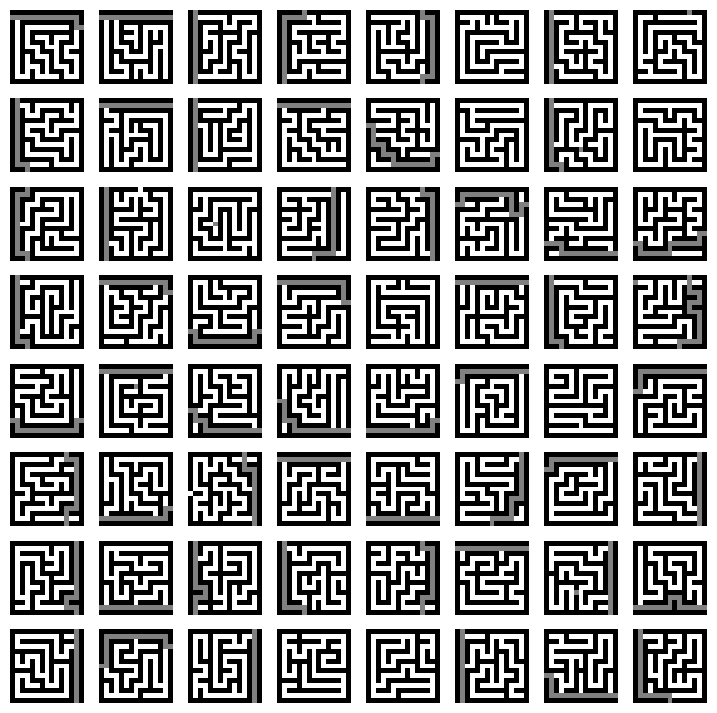

In [16]:
is_img = cfg.data.is_img

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
 
    saving_plot_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")